# Data files from Xander's tests stars

In [20]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import numpy as np
from astropy.stats import sigma_clip

#my code to write the file needed for my viewer
from dataToJson import dataToJson

In [2]:
#Xander's code
Atlas_LC = Table(fits.getdata(r"All_Big_Macc_LC_Data_xhall.fit"))
Directory_File = Table.read("Aaron_Stars_5.csv")
def get_lcdata_from_objid(objid):
    objid = int(objid)
    observations = Atlas_LC[np.where(objid == Atlas_LC["objid"])[0]]
    hjd = np.array(observations['mjd'])
    mag = np.array(observations['m'])
    mag_unc = np.array(observations['dm'])
    filters = np.array([byte for byte in observations['filter']])
    return hjd, mag, mag_unc, filters

In [59]:
#set up the data
for i in range(len(Directory_File)):
    fname = str(Directory_File["Xid"][i])+'.json'
    print(fname)

    #filter names (not visible in interactive, but should be unique strings)
    filterNames = ['c', 'o']

    #colors for data in each filter
    colors = ['#3dcfcf','#f88b1b']

    #symbols for each filter
    # the following are available Circle, Cross, Diamond, Square, Star, Triangle, Wye
    # NOTE: these may be case sensitive
    symbols = ['Circle', 'Cross']

    #sizes for the symbols
    sizes = [40, 40]

    #best fit periods for each filter (in the same order as filterNames)
    periods = [Directory_File["c_period"][i], Directory_File["o_period"][i]]

    #CMD data (dummy data for now)
    #for percentiles, all lists must be ordered in the same way (either small to large or large to small)
    CMDdata = dict()
    CMDdata['color'] = Directory_File["b_band"][i] - Directory_File["r_band"][i] 
    CMDdata['mag'] = Directory_File["g_band"][i] - (5.*np.log10(Directory_File["rest"][i]/10.))
    CMDdata['magPplus'] = [np.abs(CMDdata['mag'] - (Directory_File["g_band"][i] - (5.*np.log10(Directory_File["neg3sig"][i]/10.)))), 
                           np.abs(CMDdata['mag'] - (Directory_File["g_band"][i] - (5.*np.log10(Directory_File["neg2sig"][i]/10.)))), 
                           np.abs(CMDdata['mag'] - (Directory_File["g_band"][i] - (5.*np.log10(Directory_File["neg1sig"][i]/10.)))) ]
    CMDdata['magPminus'] = [np.abs(CMDdata['mag'] - (Directory_File["g_band"][i] - (5.*np.log10(Directory_File["pos3sig"][i]/10.)))),  
                            np.abs(CMDdata['mag'] - (Directory_File["g_band"][i] - (5.*np.log10(Directory_File["pos2sig"][i]/10.)))), 
                            np.abs(CMDdata['mag'] - (Directory_File["g_band"][i] - (5.*np.log10(Directory_File["pos1sig"][i]/10.))))]
    #this is not correct
    CMDdata['colorPplus'] = [Directory_File["b_minus_r_error"][i]*3., 
                             Directory_File["b_minus_r_error"][i]*2., 
                             Directory_File["b_minus_r_error"][i]]
    CMDdata['colorPminus'] = [Directory_File["b_minus_r_error"][i]*3., 
                              Directory_File["b_minus_r_error"][i]*2., 
                              Directory_File["b_minus_r_error"][i]]
    CMDdata['cs'] = ["#defafa","#3dcfcf","#2c3a83"]

    #light curve data, combined into dict
    fromFits = get_lcdata_from_objid((Directory_File["Atlas_ObjID"][i]))
    LCdata = dict()
    fData0 = np.where(fromFits[3] == filterNames[0])
    mMean = np.mean(fromFits[1][fData0])
    for f in filterNames:
        fData = np.where(fromFits[3] == f)
        LCdata[f] = dict()
        mag = fromFits[1][fData]
        hjd = fromFits[0][fData]
        err = fromFits[2][fData]
        
        meanErr = np.mean(err)
        #sigma clipping, like Nick did
        #outside = np.logical_or(np.logical_or((mag < 4),(mag > 30)), (err > 5*meanErr))
        outside = np.logical_or((mag < 4),(mag > 30))
        clipped_obs = np.copy(outside)
        clipped_obs[~outside] = sigma_clip(mag[~outside], sigma=5, maxiters=1).mask
    
   
        LCdata[f]['hjd'] = hjd[~clipped_obs]
        LCdata[f]['mag'] = mMean - mag[~clipped_obs]
        LCdata[f]['err'] = err[~clipped_obs]

    #create the output json
    dataToJson(filterNames, colors, symbols, sizes, CMDdata, LCdata, periods, filename=fname)


37.json
182.json
180.json
2.json
210.json
791.json
154.json


In [5]:
import matplotlib.pyplot as plt

210
170 170 170 170 0
160 160 160 160 1


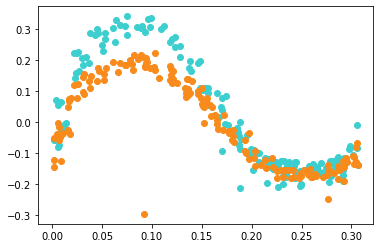

In [51]:
i=4
print(Directory_File["Xid"][i])
fromFits = get_lcdata_from_objid((Directory_File["Atlas_ObjID"][i]))
periods = [Directory_File["c_period"][i], Directory_File["o_period"][i]]

f, ax = plt.subplots()
for i,f in enumerate(filterNames):
    fData = np.where(fromFits[3] == f)
    mag = fromFits[1][fData]
    hjd = fromFits[0][fData]
    
    outside = np.logical_or((mag < 4),(mag > 30))
    clipped_obs = np.copy(outside)
    clipped_obs[~outside] = sigma_clip(mag[~outside], sigma=5, maxiters=1).mask
    print(len(clipped_obs), len(outside), len(mag), len(mag[~outside]), len(mag[clipped_obs]))
    
    ax.plot(hjd[~clipped_obs] % periods[0],np.mean(mag[~clipped_obs]) - mag[~clipped_obs],'o',color=colors[i])
    #ax.plot(fromFits[0][fData], np.mean(fromFits[1][fData]) - fromFits[1][fData] ,'o',color=colors[i])
